In [5]:
# Imports

import os
import json
import tqdm
import yaml

import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm

In [8]:
%%bash
mkdir -p results
fusermount -uz results
sshfs compute.ies:/mnt/work/deep_al/results/active_learning results
ls results

fusermount: entry for /home/denis/Documents/projects/uncertainty_evaluation/notebooks/evaluation/results not found in /etc/mtab


CIFAR10
SVHN


In [9]:

def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_results(path, train_results=False):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
        
    results = {}

    exp_json = path / 'results.json'
    exp_cfg = path / '.hydra' / 'config.yaml'
    try:
        cfg =  OmegaConf.load(exp_cfg)
        data = load_json(exp_json)
    except:
        print(f'{path} has missing results.')
        return

    results['cfg'] = cfg
    results['results'] = data
    return results


def get_experiments(result_path, glob_pattern, train_results=False):
    experiments = []
    for exp_path in result_path.glob(glob_pattern):
        d = load_results(exp_path, train_results=train_results)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

def get_metric_values(experiments, metrics=['n_labeled_samples'], test_metrics=['test_acc1']):
    metric_values = {key: [] for key in test_metrics}
    metric_values.update({key: [] for key in metrics})
    for al_results in experiments:
        if al_results is None:
            continue
        al_results = al_results['results']

        for metric in test_metrics:
            vals = [d['test_stats'][metric] for cycle, d in al_results.items()]
            metric_values[metric].append(vals)

        for metric in metrics:
            vals = [d[metric] for cycle, d in al_results.items()]
            metric_values[metric].append(vals)

    return {key: np.array(val) for key, val in metric_values.items()}


## General Results

### Low Budget Domain

In [10]:
dataset = 'CIFAR10'
low_budget_experiments = {
    # Deterministic ResNet18 
    'random_det': f'results/{dataset}/resnet18/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
    'uncertainty_det': f'results/{dataset}/resnet18/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{9}/',
    # 'coreset_det': f'results/{dataset}/resnet18/coreset/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{10}/',
    # 'badge_det': f'results/{dataset}/resnet18/badge/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{10}/',
    # SNGP ResNet18 
    # 'random_sngp': f'results/{dataset}/resnet18_sngp/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{10}/',
    # 'uncertainty_sngp': f'results/{dataset}/resnet18_sngp/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{10}/',
    # 'coreset_sngp': f'results/{dataset}/resnet18_sngp/coreset/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{10}/',
    # Deterministic LeNet
    # 'random_lenet': f'results/{dataset}/lenet/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{10}/',
    # 'uncertainty_lenet': f'results/{dataset}/lenet/uncertainty/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{10}/',
    # 'coreset_lenet': f'results/{dataset}/lenet/coreset/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{10}/',
}

results = {}
for exp_name, exp_path in tqdm(low_budget_experiments.items()):
    exp_results = get_experiments(Path(exp_path), 'seed*')
    metrics = get_metric_values(exp_results)
    results[exp_name] = metrics

100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


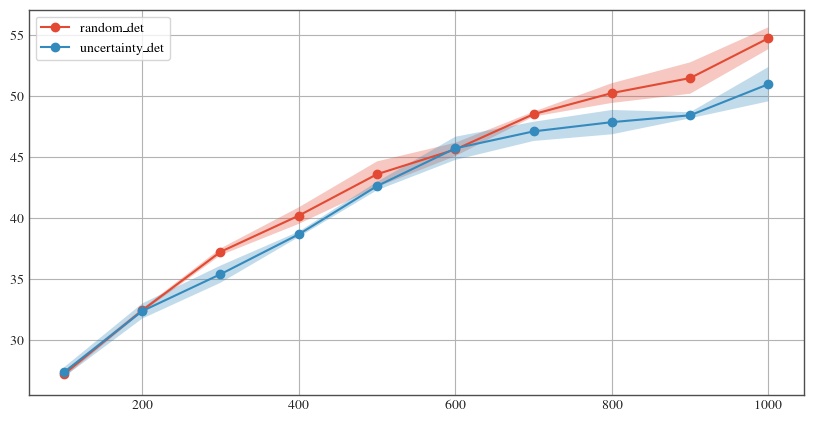

In [11]:
show_std = True
for strat_name, metrics in results.items():
    n_labeled_samples = np.mean(metrics['n_labeled_samples'], axis=0)
    acc = np.mean(metrics['test_acc1'], axis=0)
    acc_std = np.std(metrics['test_acc1'], axis=0)
    plt.plot(n_labeled_samples, acc, '-o', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, acc - acc_std, acc+acc_std, alpha=.3)
    plt.legend()

### High Budget Domain

#### CIFAR10

In [6]:
high_budget_experiments = {
    # Deterministic ResNet18
    'random_det': f'results/CIFAR10/resnet18/random/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    'uncertainty_det': f'results/CIFAR10/resnet18/uncertainty/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    'coreset_det': f'results/CIFAR10/resnet18/coreset/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    'badge_det': f'results/CIFAR10/resnet18/badge/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    'predefined_det': f'results/CIFAR10/resnet18/predefined/resnet18_uncertainty/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    ## SNGP ResNet18
    # 'random_sngp': f'results/CIFAR10/resnet18_sngp/random/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    # 'uncertainty_sngp': f'results/CIFAR10/resnet18_sngp/uncertainty/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    # 'coreset_sngp': f'results/CIFAR10/resnet18_sngp/coreset/N_INIT{1000}__ACQ_SIZE{1000}__N_ACQ{10}/',
    ## MISC
    # 'resnet18_high_lr': f'results/CIFAR10/resnet18/uncertainty/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{n_acq}__lr0.1/',
    # 'random': f'results/CIFAR10/resnet18/random/N_INIT{2000}__ACQ_SIZE{2000}__N_ACQ{4}/',
}

results = {}
for exp_name, exp_path in tqdm(high_budget_experiments.items()):
    exp_results = get_experiments(Path(exp_path), 'seed*')
    metrics = get_metric_values(exp_results)
    results[exp_name] = metrics

100%|██████████| 4/4 [00:18<00:00,  4.75s/it]


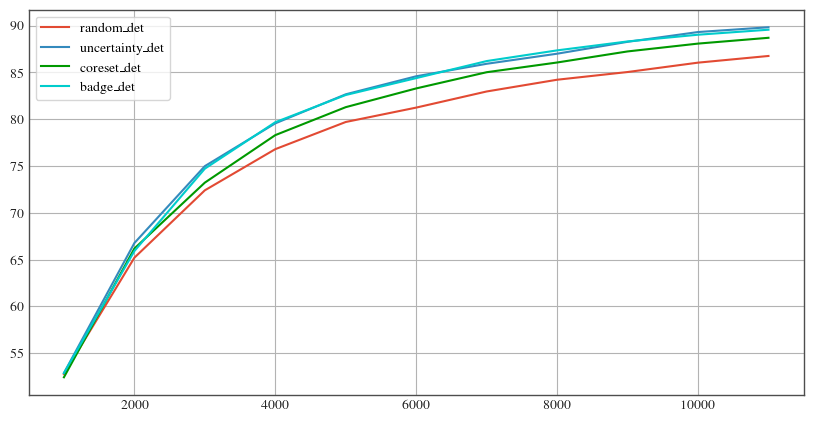

In [9]:
show_std = False
for strat_name, metrics in results.items():
    n_labeled_samples = np.mean(metrics['n_labeled_samples'], axis=0)
    acc = np.mean(metrics['test_acc1'], axis=0)
    acc_std = np.std(metrics['test_acc1'], axis=0)
    plt.plot(n_labeled_samples, acc, label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, acc - acc_std, acc+acc_std, alpha=.3)
    plt.legend()

#### SVHN

In [18]:
high_budget_experiments = {
    # Deterministic ResNet18
    'random_det': f'results/SVHN/resnet18/random/N_INIT{500}__ACQ_SIZE{500}__N_ACQ{10}/',
    'uncertainty_det': f'results/SVHN/resnet18/uncertainty/N_INIT{500}__ACQ_SIZE{500}__N_ACQ{10}/',
    'badge_det': f'results/SVHN/resnet18/badge/N_INIT{500}__ACQ_SIZE{500}__N_ACQ{10}/',
    # 'coreset_det': f'results/SVHN/resnet18/coreset/N_INIT{500}__ACQ_SIZE{500}__N_ACQ{10}/',
    ## SNGP ResNet18
    # 'random_sngp': f'results/SVHN/resnet18_sngp/random/N_INIT{500}__ACQ_SIZE{1000}__N_ACQ{10}/',
    # 'uncertainty_sngp': f'results/SVHN/resnet18_sngp/uncertainty/N_INIT{500}__ACQ_SIZE{1000}__N_ACQ{10}/',
    # 'coreset_sngp': f'results/SVHN/resnet18_sngp/coreset/N_INIT{500}__ACQ_SIZE{1000}__N_ACQ{10}/',
    ## MISC
    # 'resnet18_high_lr': f'results/SVHN/resnet18/uncertainty/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{n_acq}__lr0.1/',
    # 'random': f'results/SVHN/resnet18/random/N_INIT{2000}__ACQ_SIZE{2000}__N_ACQ{4}/',
}

results = {}
for exp_name, exp_path in tqdm(high_budget_experiments.items()):
    exp_results = get_experiments(Path(exp_path), 'seed*')
    metrics = get_metric_values(exp_results)
    results[exp_name] = metrics

100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


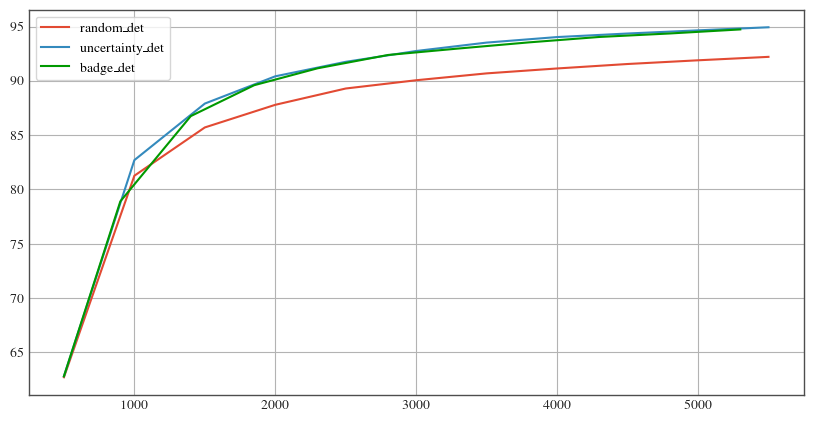

In [21]:
show_std = False 
for strat_name, metrics in results.items():
    n_labeled_samples = np.mean(metrics['n_labeled_samples'], axis=0)
    acc = np.mean(metrics['test_acc1'], axis=0)
    acc_std = np.std(metrics['test_acc1'], axis=0)
    plt.plot(n_labeled_samples, acc, label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, acc - acc_std, acc+acc_std, alpha=.3)
    plt.legend()

In [12]:
from torchvision.datasets import CIFAR10

path = Path(high_budget_experiments['coreset'])

dataset = CIFAR10('/tmp', train=True, download=True)
exp_results = get_experiments(path, 'seed*')
for i in range(10):
    cycle = f'cycle{i}'

    classes = []
    classes_count = []
    for seed_result in exp_results:
        if seed_result is None:
            continue
        sampled_classes_seed = []
        labeled_indices_seed = seed_result['results'][cycle]['labeled_indices']
        for idx in labeled_indices_seed:
            _, lbl = dataset[idx]
            sampled_classes_seed.append(lbl)
        classes_seed, classes_count_seed  = np.unique(sampled_classes_seed, return_counts=True)
        classes.append(classes_seed)
        classes_count.append(classes_count_seed)

    classes = np.array(classes)
    classes_count = np.array(classes_count)
    plt.bar(np.mean(classes, axis=0), np.mean(classes_count, axis=0))
    plt.xticks(np.mean(classes, axis=0), dataset.classes, rotation=45)
    plt.show()
    # plt.bar(*np.unique(sampeled_classes, return_counts=True))

KeyError: 'coreset'

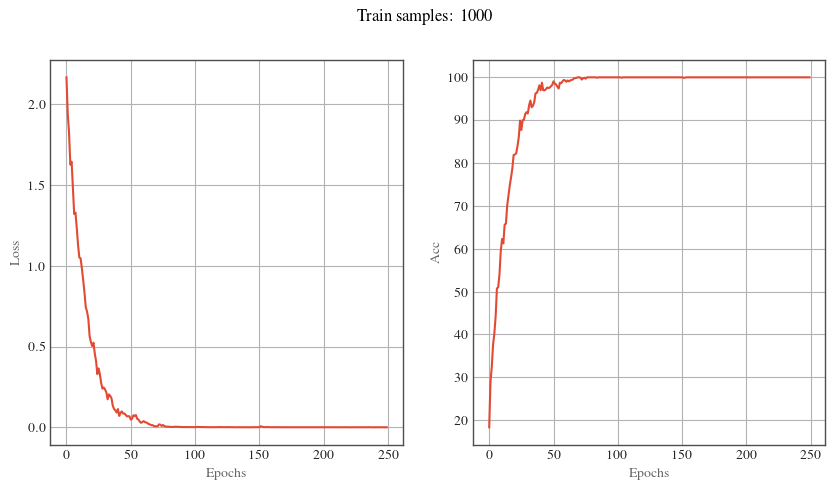

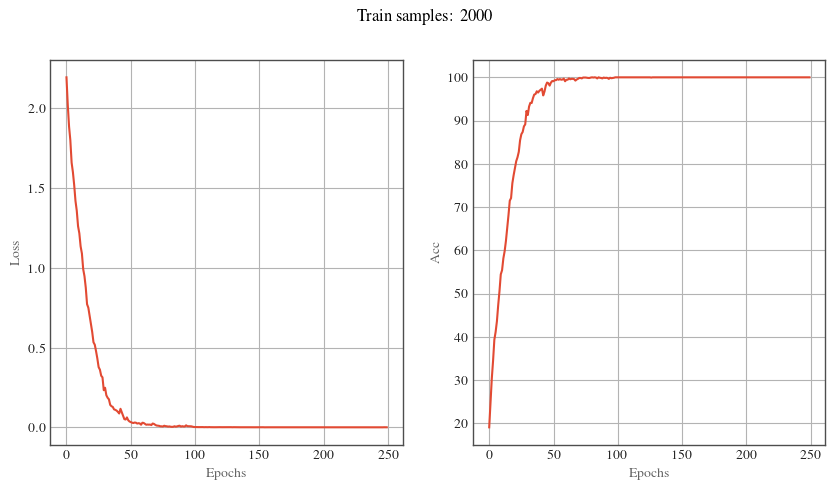

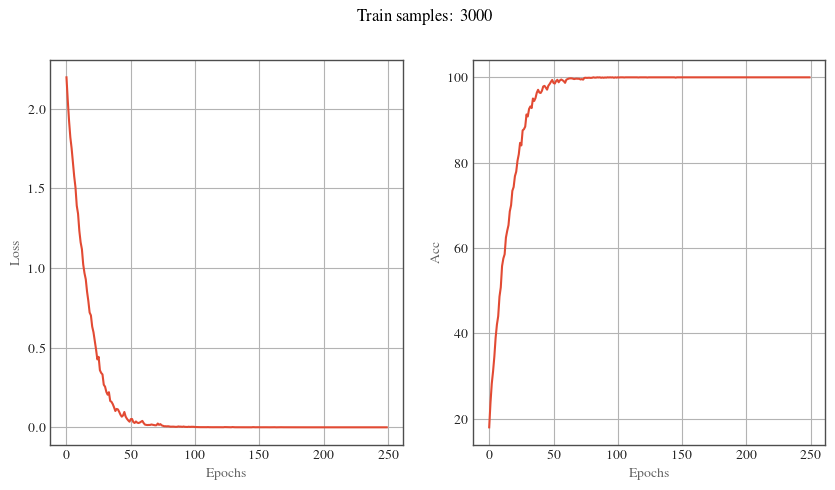

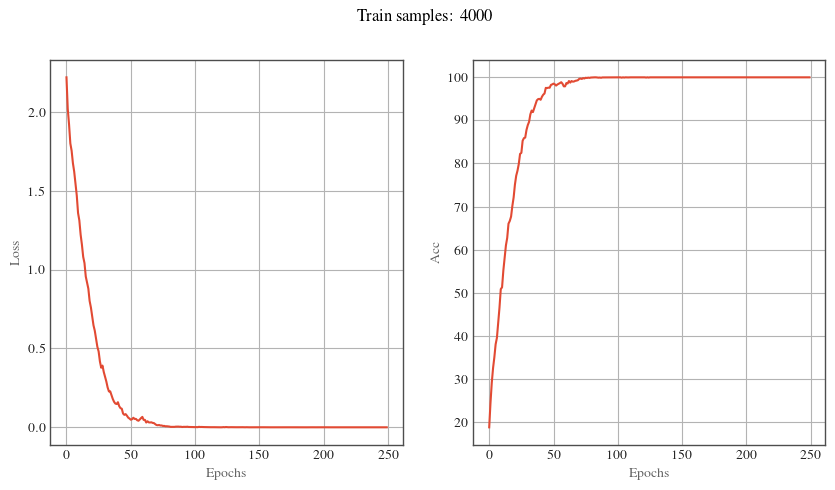

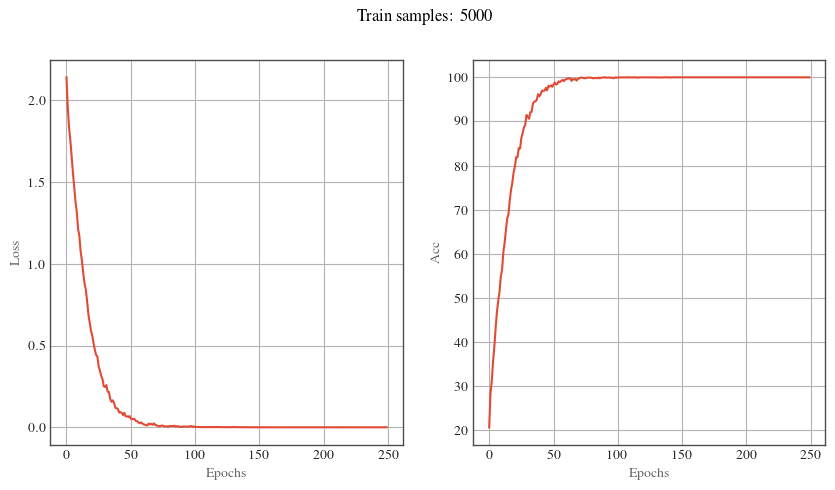

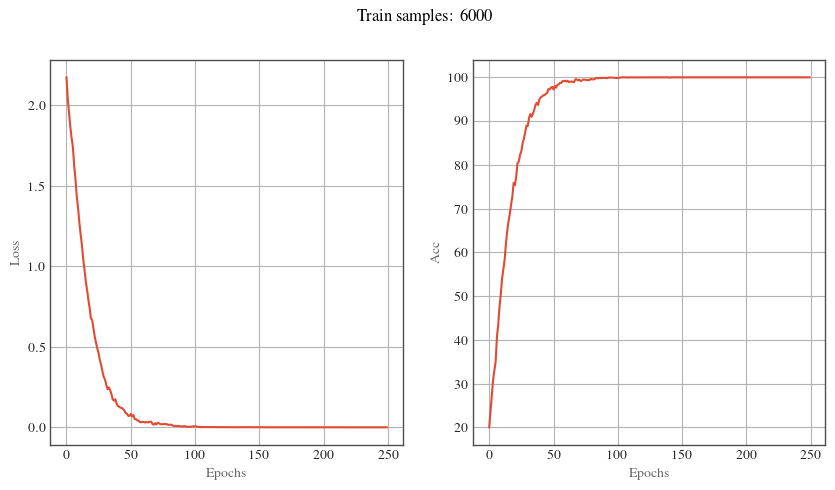

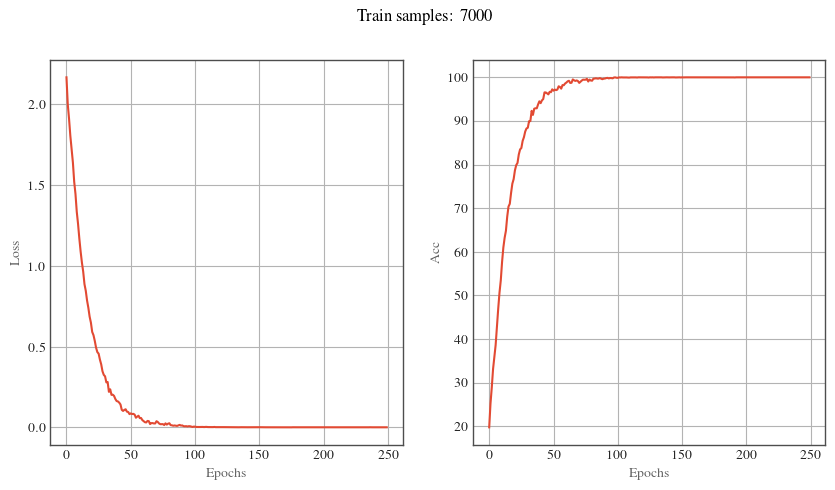

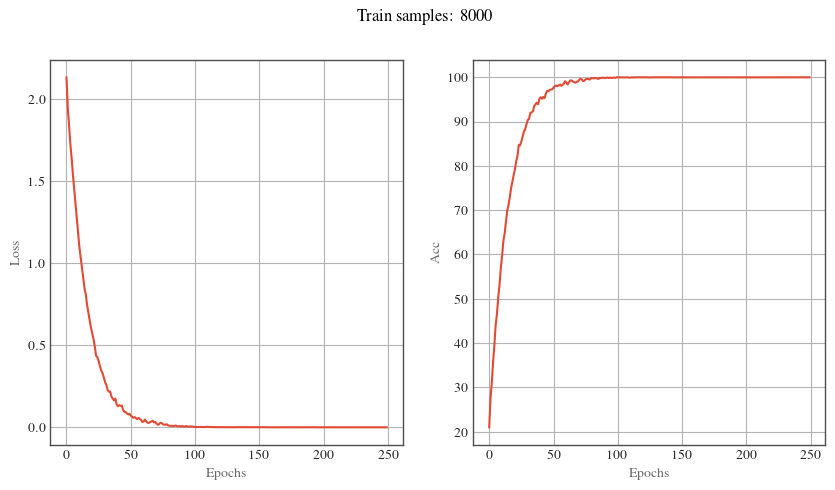

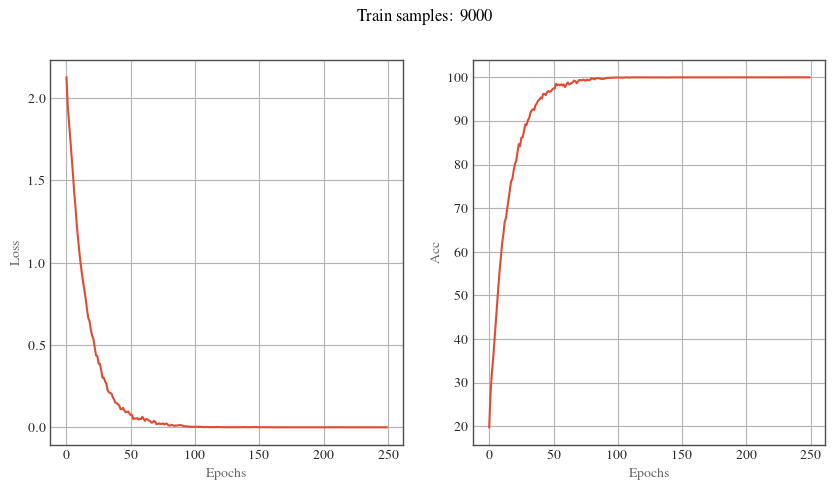

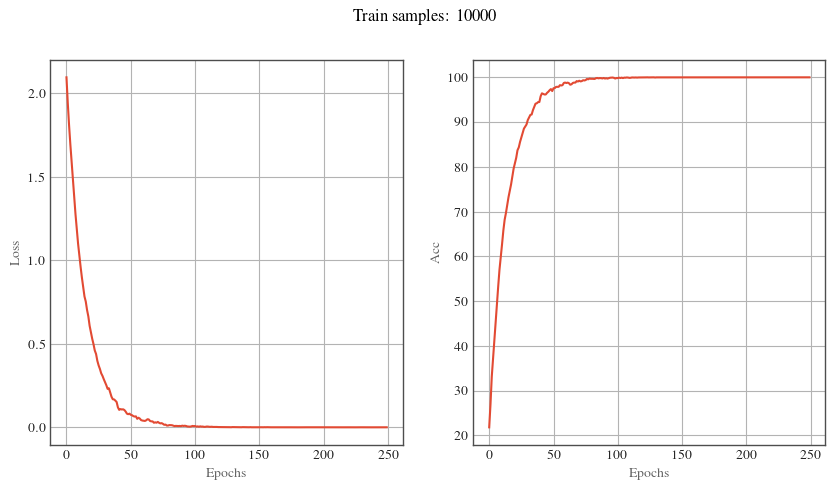

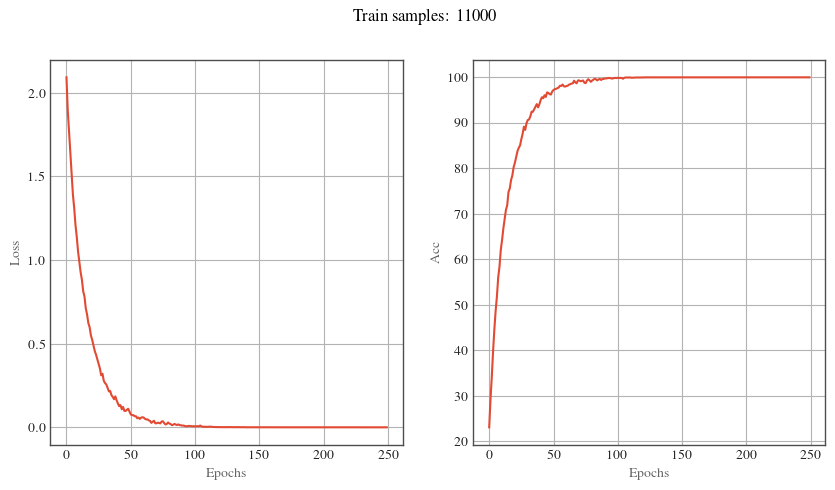

In [11]:
experiment_results = exp_results[0]['results']
for key in experiment_results:
    cycle_stats = experiment_results[key]
    train_history = cycle_stats['train_history']

    fig = plt.figure()
    fig.suptitle('Train samples: %s' % cycle_stats['n_labeled_samples'])
    plt.subplot(121)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot([d['train_loss'] for d in train_history])

    plt.subplot(122)
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.plot([d['train_acc1'] for d in train_history])
    plt.show()